In [1]:
import mxnet as mx
from mxnet import gluon
from mxnet.gluon.nn import Dense, Conv2D, Flatten, Dropout, HybridSequential, HybridBlock, MaxPool2D
import numpy as np

# Gluon Hybridization Demo
Gluon is an imperative library on top of MXNet that utilizes `HybridBlock`s to allow conversion into symbolic graphs. The following is an example of a residual block implemented as a `HybridBlock`. The `F` in `hybrid_forward` will be `mxnet.ndarray` if `x` is an `ndarray`, and it will be `mxnet.symbol` if `x` is a `symbol`. Since MXNet's operations are uniform in most cases between its two APIs, the conversion works in this way.

In [2]:
class ResidualBlock(HybridBlock):
    def __init__(self, channels, activation, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        with self.name_scope():
            self.c1 = Conv2D(channels=channels, activation=activation, 
                             kernel_size=kernel_size, strides=1, padding=1)
            self.c2 = Conv2D(channels=channels, activation=activation, 
                             kernel_size=kernel_size, strides=2, padding=1)
            self.ident_sample = Conv2D(channels=channels, kernel_size=1, strides=2)
    
    def hybrid_forward(self, F, x):
        net = self.c1(x)
        net = self.c2(net)
        ident = self.ident_sample(x)
        net = F.add_n(net, ident)
        return net

In [3]:
model = HybridSequential()
model.add(ResidualBlock(64, "relu", 3))
model.add(ResidualBlock(128, "relu", 3))
model.add(ResidualBlock(256, "relu", 3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10))

In [4]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [5]:
ctx = mx.cpu()
model.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

Since our model is imperative, we can manipulate it in line. For example:

In [6]:
model(mx.nd.ones((100,32,32,3)))[0]


[ 0.21128324 -0.38900724 -0.4446955  -0.12091288  1.06250465  0.13343033
  0.24158487 -0.19841106  0.4619942  -0.05019611]
<NDArray 10 @cpu(0)>

Now we can call `hybridize` to automatically construct a symbolic graph. Then we can only run with a `symbol`, and we get a `symbol` in return.

In [7]:
model.hybridize()

In [8]:
model(mx.sym.ones((100,3,32,32)))[0]

<Symbol dense1_fwd>

We can even declare an MXNet variable and run it through our net to get the native MXNet `symbol` out of Gluon:

In [9]:
data = mx.sym.Variable('data')
sym = model(data)

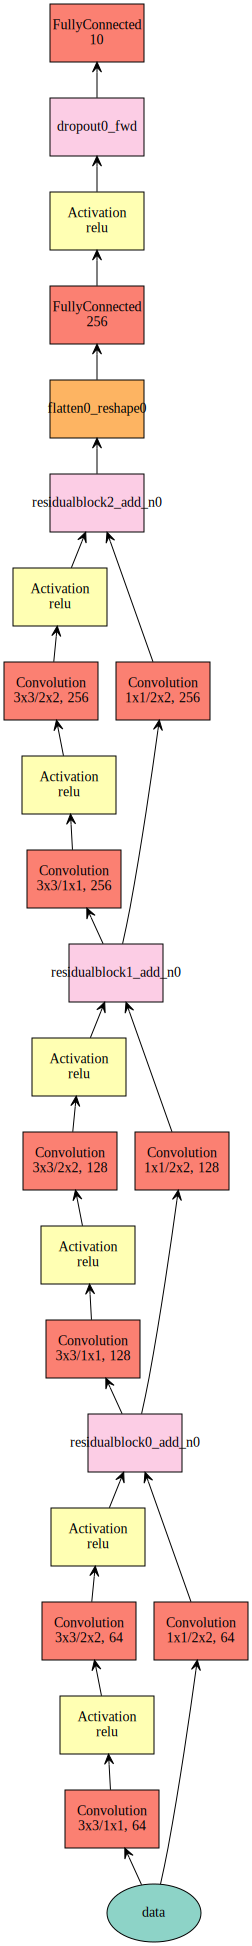

In [10]:
mx.viz.plot_network(sym)